# Анализ оттока клиентов банка "Метанпром"

# Содержание

1. **[Шаг 1. Постановка цели исследования.](#step1_0)**


2. **[Шаг 2. Загрузка данных и подготовка их к анализу.](#step2_0)**


3. **[Шаг 3. Предобработка данных.](#step3_0)**

    
4. **[Шаг 4. Исследовательский анализ данных.](#step4_0)** 

    
5. **[Шаг 5. Выделение портретов пользовтаелей склонных к уходу.](#step5_0)**


6. **[Шаг 6. Формулирование и проверка статистических гипотез.](#step6_0)**


7. **[Шаг 7. Итоговые выводы и рекомендации.](#step7_0)**


8. **[Шаг 8. Презентация для заказчика.](#step8_0)**

# Шаг 1. Постановка цели исследования. <a id="step1_0"></a>

**Наша задача проанализировать клиентов регионального банка "Метанпром", который располагается в Ярославле и областных городах: Ростов Великий и Рыбинск, и выделить портрет клиентов, которые склонный уходить из банка.**

У нас имеется датасет, который содрежит данные о клиентах банка и имеет следующие колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

# Шаг 2. Загрузка данных и подготовка их к анализу. <a id="step2_0"></a>

In [7]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('/datasets/bank_dataset.csv')

In [9]:
df.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


Данный выглядят корректно, приступим к предобработке.

# Шаг 3. Предобработка данных. <a id="step3_0"></a>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


10000 строк, в одной колонке примерно треть пропусков, типы данных корректны.

In [11]:
# приведем названия столбцов к нижнему регистру
df.columns = map(str.lower, df.columns)

In [12]:
# дубликаты отсутсвуют
df.duplicated().sum()

0

In [14]:
#конкретно в колоне userid тоже все значения уникальны, и по сути ее можно удалить, т.к она не несет никакой полезной информации
df.duplicated(['userid']).sum()

0

In [15]:
df = df.drop('userid', axis = 1)

In [16]:
df.describe()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


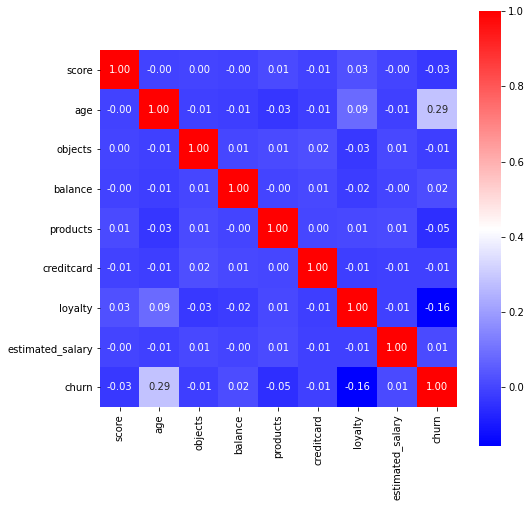

In [17]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(),annot=True, square=True, fmt = '.2f', cmap='bwr');

В таблице отсутвуют колонки, имеющие сильную линейную корреляцию, значит они нам все пригодятся.

Что же на счет пропусков в колонке <code>balance</code>, то пока оставим как есть, так как удаление такого количества строк не целесообразно, это практически треть всего датасета, а заполнение средним или медианным значением сильно исказит этот столбец.

# Шаг 4. Исследовательский анализ данных.<a id="step4_0"></a>

Цель нашего исследования - составить портрет пользователей, которые склонны уходить из банка, т.е. нам необходимо найти явную (и неявную) разницу между ними, и теми кто остался. Эта информация имеется в столбце <code>churn</code>, по нему и будет смотреть.

Для начала посмотрим, какой процент от всего датасета занимают ушедшие.

In [18]:
# 20% клиентов
df['churn'].mean()

0.2037

Посмотрим на средние значения признаков в двух группах.

In [19]:
df.groupby('churn').mean()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,
0,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


Тут можно выделить, что **средний возраст ушедших выше чем тех кто остался**, примерно на 7 с лишним лет. Также ушедшие клиенты **менее активны**.

Здесь я столкнулся с проблемой наличия пропусков при попытке построить графики распределения признаков, так как библиотека <code>seaborn</code> не может построить гистограмму по такому столбцу, в отличии от метода <code>hist()</code> в <code>pandas</code>. В целом это не проблема, но я решил избавиться от пропусков. Сначала я поробовал использовать методы машинного обучения, но линейная регрессия и случайный лес предсказали, что все значения находятся в диапазоне от 115000 до 125000, что неестественно, хотя имеет смысл для той же линейной регрессии, ведь матрица корреляций показывает что линейная зависимость между <code>balance</code> и остальными столбцами отсутвует. Самое логичное тут считать что пропуски это нулевой баланс, ведь такое действиетльно может быть, это нормально для счетов клиентов, однако такие значение отсутвуют в таблице изначально. Видимо пропуски и подразумевают под собой 0.

Для начала посмотрим как выглядит признак до обработки.

In [20]:
df = df.fillna(0)

Теперь построим столбчатые диаграммы и распределения признаков для тех кто ушел и тех кто остался.

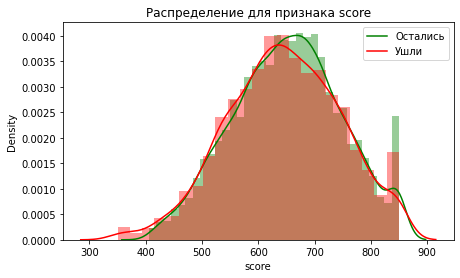

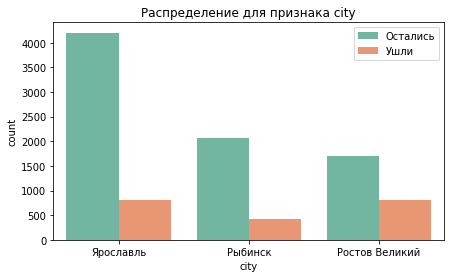

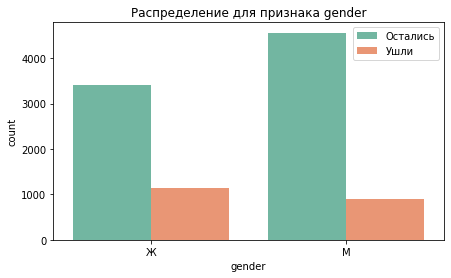

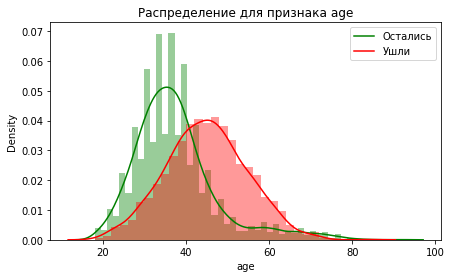

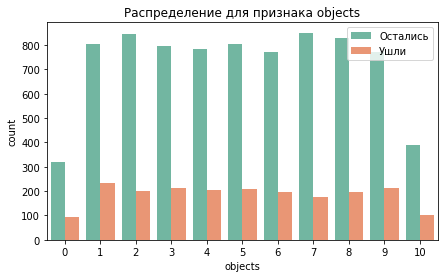

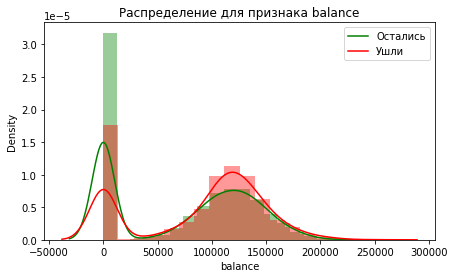

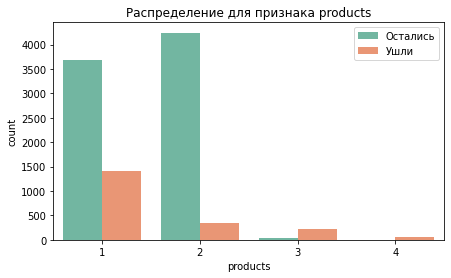

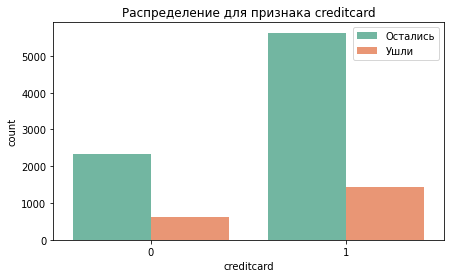

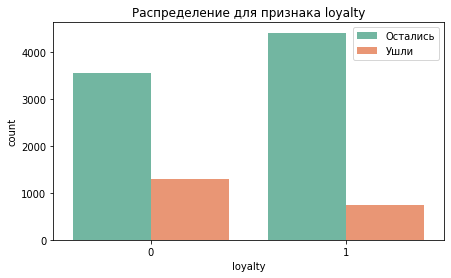

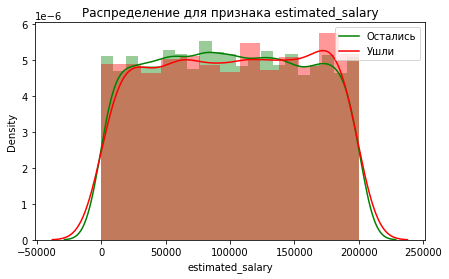

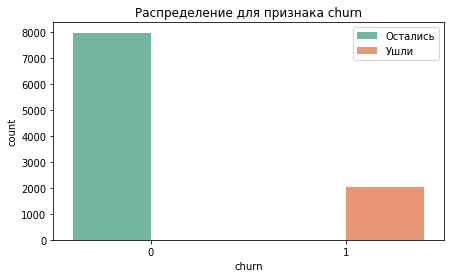

In [21]:
for col in df.columns:
    if len(df[col].unique()) > 11:
        plt.figure(figsize=(7, 4))
        sns.distplot(df.query('churn == 0')[col],color='g')
        sns.distplot(df.query('churn == 1')[col], color='r')
        plt.legend(labels = ('Остались', 'Ушли'), loc='upper right')
        plt.title('Распределение для признака ' + col)
        plt.show()
    else:
        plt.figure(figsize=(7, 4))
        sns.countplot(x=col, hue='churn', data=df, palette='Set2')
        plt.legend(labels = ('Остались', 'Ушли'), loc='upper right')
        plt.title('Распределение для признака ' + col)
        plt.show()

Помимо уже упомянутого возраста и активности клиента мы можем увидеть, что люди проживающие в городе **1**, он же закодированный **Ростов Великий**, более склонны к уходу. Также разница видна разбивке по полу, на это надо будет посмореть по лучше. Как и на наличе продуктов у клиента, явно видно что ниболее лояльными клиентами являются те, кто имеет всего 2 продукта.

Построим сводные таблицы по заинтересовавшим нас признакам и посчитав среднее по оттоку.

In [22]:
df.groupby('city')['churn'].agg(['count','mean'])

,count,mean
city,,
Ростов Великий,2509,0.324432
Рыбинск,2477,0.166734
Ярославль,5014,0.161548


Тут четко видно, что клиенты из **Ростова Великого уходят в 2 раза чаще** от банка, чем в других городах.

In [23]:
df.groupby('gender')['churn'].agg(['count','mean'])

,count,mean
gender,,
Ж,4543,0.250715
М,5457,0.164559


Более сколнны к уходу **женщины**.

In [24]:
df.groupby('products')['churn'].agg(['count','mean'])

,count,mean
products,,
1,5084,0.277144
2,4590,0.075817
3,266,0.827068
4,60,1.000000


Тут самое любопытное. **Наличие 2 продуктов**, которыми пользуется клиент, **значительно снижает вероятность его ухода**, в сравеннии с всего одим продуктом. Но при этом если продуктов больше чем два, то клиент практически наверняка уйдет.

Инетресно посмотерть как на распределения признаков влияет принадлежность к каждому из городов. Построим точно такие-же графики, но в разбивке по городу.

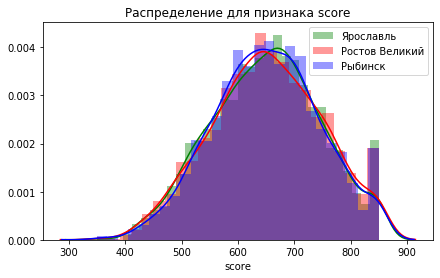

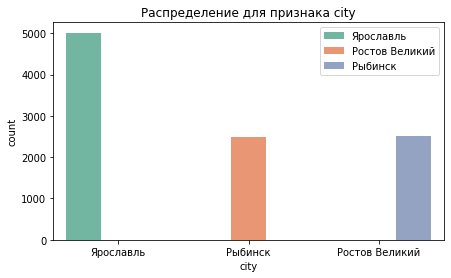

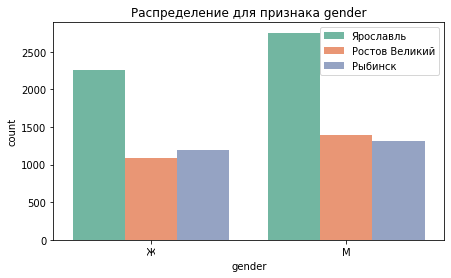

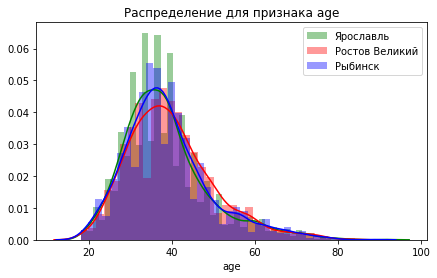

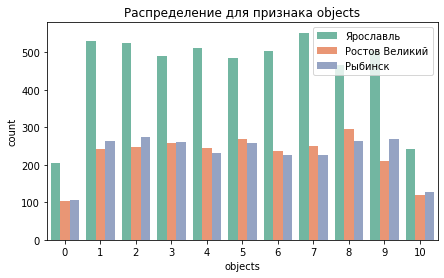

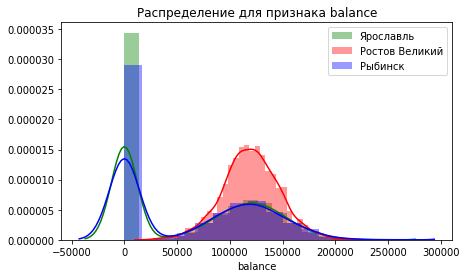

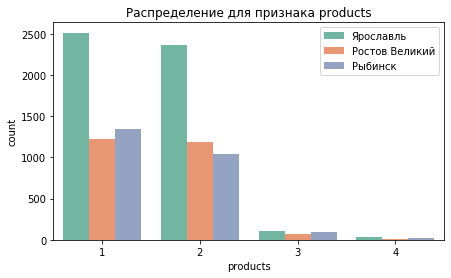

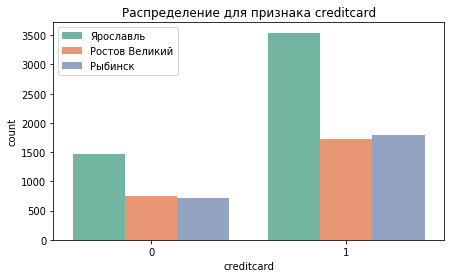

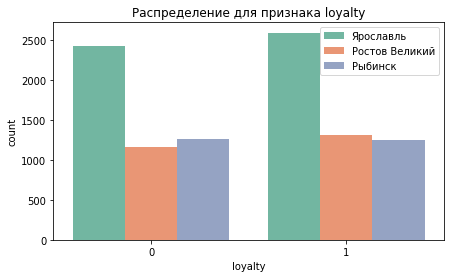

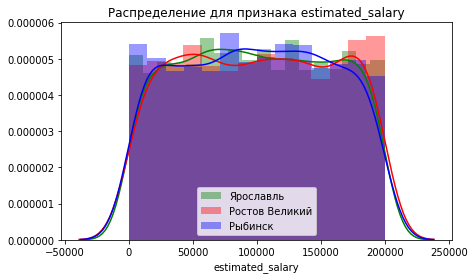

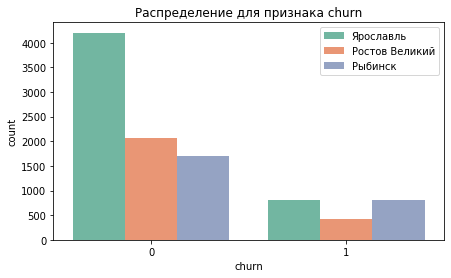

In [19]:
for col in df.columns:
    if len(df[col].unique()) > 11:
        plt.figure(figsize=(7, 4))
        sns.distplot(df.query('city == "Ярославль"')[col],color='g')
        sns.distplot(df.query('city == "Ростов Великий"')[col], color='r')
        sns.distplot(df.query('city == "Рыбинск"')[col], color='b')
        plt.legend(labels = ('Ярославль', 'Ростов Великий', 'Рыбинск'))
        plt.title('Распределение для признака ' + col)
        plt.show()
    else:
        plt.figure(figsize=(7, 4))
        sns.countplot(x=col, hue='city', data=df, palette='Set2')
        plt.legend(labels = ('Ярославль', 'Ростов Великий', 'Рыбинск'))
        plt.title('Распределение для признака ' + col)
        plt.show()

Здесь весьма интересное наблюдение. Мы заполнили все пропуки нулями, и на гистограмме видно, что у клиентов из Ростова Великого небыло ни одного пропуска. Объяснений такой аномалии у меня нет.

# Шаг 5. Выделение портретов пользовтаелей склонных к уходу. <a id="step5_0"></a>

Мы уже имеем некоторое представление о пользователях, посмотрим, сможем ли мы найти какие-либо инсайты используя методы машинного обучения. Да и в целом, раз цель исследования это выделение портрета клиентов склонных к уходу, то было бы полезно иметь предективную модель и выявлять клиентов склонных к уходу до того, как эти самые клиенты безвозвратно покинут банк.

Использую метод OneHotEncoder для обработки признаков город и пол.

In [25]:
df = pd.get_dummies(df, columns = df.columns[1:3])

In [26]:
df.head()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,1,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0


Разделим данные на обучающую и тестовую выборки.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis = 1), df['churn'],
                                                    test_size=0.2, stratify=df['churn'], random_state=8)

Протестируем логистическую регрессию.

In [23]:
lg = LogisticRegression(solver='liblinear', random_state = 8)
lg.fit(X_train, y_train)
lg_pred = lg.predict(X_test)
lg_proba = lg.predict_proba(X_test)[:,1]

In [24]:
def print_all_metrics(y_true, y_pred, y_proba):
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [25]:
print_all_metrics(y_test, lg_pred, lg_proba)

	Accuracy: 0.79
	Precision: 0.38
	Recall: 0.05
	F1: 0.09
	ROC_AUC: 0.65


Все показатели оказались очень плохими.

Попробуем, что покажет случайны лес.

Я закомментировал следующие 2 ячейки, что бы они не запускались каждый раз при запуске ноутбука.

In [26]:
"""rfc = RandomForestClassifier(random_state = 0)
params = {
    'n_estimators': np.arange(100,501,50),
    'max_depth': np.arange(5, 16)
}
gs = GridSearchCV(rfc, params, 'f1', cv=5)
gs.fit(X_train,y_train)"""

"rfc = RandomForestClassifier(random_state = 0)\nparams = {\n    'n_estimators': np.arange(100,501,50),\n    'max_depth': np.arange(5, 16)\n}\ngs = GridSearchCV(rfc, params, 'f1', cv=5)\ngs.fit(X_train,y_train)"

In [27]:
"""gs.best_score_, gs.best_params_"""

'gs.best_score_, gs.best_params_'

In [28]:
rfc = RandomForestClassifier(n_estimators = 250, max_depth = 15, random_state = 0)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
rfc_proba = rfc.predict_proba(X_test)[:,1]
print_all_metrics(y_test, rfc_pred, rfc_proba)

	Accuracy: 0.86
	Precision: 0.79
	Recall: 0.44
	F1: 0.57
	ROC_AUC: 0.86


In [29]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print(importances)

                     importance
feature                        
age                       0.252
products                  0.142
balance                   0.136
score                     0.134
estimated_salary          0.133
objects                   0.078
loyalty                   0.044
city_Ростов Великий       0.022
creditcard                0.018
city_Рыбинск              0.010
city_Ярославль            0.010
gender_Ж                  0.010
gender_М                  0.009


Для леса самым важным признаком, влияющим на отток, оказался возраст клиентов, к сожалению это для нас не новость, мы это обнаружили на этапе исследовательского анализа.

# Шаг 6. Формулирование и проверка статистических гипотез. <a id="step6_0"></a>

Первая гипотеза, которую нам необходимо проверить, это различие в доходе между ушедшими клиентами, и теми, которые остались.

Сформулируем саму гипотезу:

Нулевая гипотеза **H0**: распределение дохода ушедших и распределении дохода оставшихся **одинаково**

Альтернативня гипотеза **H1**:  распределение доход двух групп **неодинаково**

Критическим уровнем статистической значимости для нашего теста будем считать = **0.05.**

Для начала проверим распределения на нормальность, хотя по построенному графику вов ремя исследовательского анализа и так видно что оно не нормально. Удобнее всего построить график qq plot и посмотреть глазами.

In [30]:
churn_estimated_salary = df.query('churn == "1"')['estimated_salary']
no_churn_estimated_salary = df.query('churn == "0"')['estimated_salary']

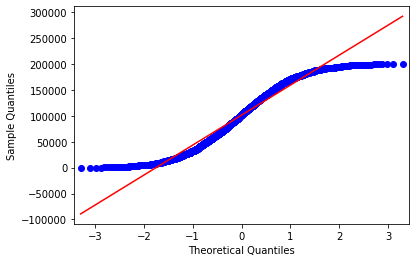

In [31]:
from statsmodels.graphics.gofplots import qqplot
qqplot(churn_estimated_salary, line='s')
plt.show()

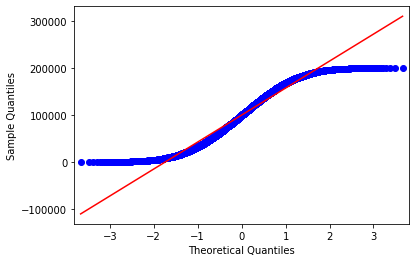

In [32]:
qqplot(no_churn_estimated_salary, line='s')
plt.show()

Распределение не нормальное, будем использовать критерий Манна-Уитни для проверки гипотезы.

In [33]:
alpha = .05 # уровень статистической значимости
results = st.mannwhitneyu(churn_estimated_salary, no_churn_estimated_salary)

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Распределение двух групп неодинаково')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Распределение двух групп одинаково')

p-значение:  0.11352575465076892
Не получилось отвергнуть нулевую гипотезу. Распределение двух групп одинаково


Следующий статистический тест, который я хотел бы проверить, касается распределения баллов кредитного скоринга, есть ли разница между ушедшими и теми, кто остался. Так по графику, построенному во время исследовательского анализа особой разница не видно.


In [34]:
churn_score = df.query('churn == "1"')['score']
no_churn_score = df.query('churn == "0"')['score']

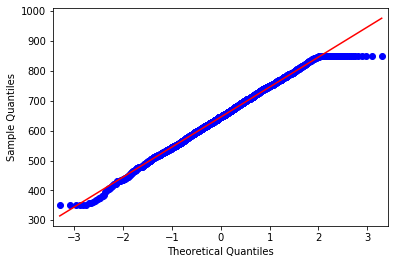

In [35]:
qqplot(churn_score, line='s')
plt.show()

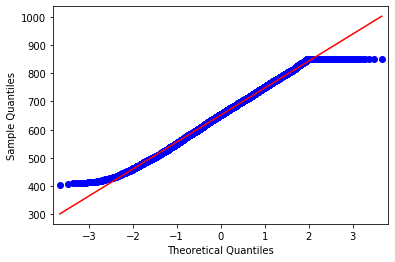

In [36]:
qqplot(no_churn_score, line='s')
plt.show()

Так же будем использовать критерий Манна-Уитни для проверки гипотезы.

Нулевая гипотеза **H0**: распределение баллов кредитного скоринга ушедших и распределение баллов кредитного скоринга оставшихся **одинаково**

Альтернативня гипотеза **H1**:  распределение баллов кредитного скоринга двух групп **неодинаково**

Критическим уровнем статистической значимости для нашего теста так же будем считать = **0.05.**

In [37]:
alpha = .05 # уровень статистической значимости
results = st.mannwhitneyu(churn_score, no_churn_score)

print(f'Средний балл кредитного скоринга ушедших = {churn_score.mean()}')
print(f'Средний балл кредитного скоринга оставшихся = {no_churn_score.mean()}')

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Распределение двух групп неодинаково')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Распределение двух групп одинаково')

Средний балл кредитного скоринга ушедших = 645.3514972999509
Средний балл кредитного скоринга оставшихся = 651.8531960316463
p-значение:  0.00993433058636417
Отвергаем нулевую гипотезу. Распределение двух групп неодинаково


Распределение баллов кредитного скоринга в двух группах **имеет статистически значимые различия**.

# Шаг 7. Итоговые выводы и рекомендации. <a id="step7_0"></a>

**Мы проанализировали клиентов регионального банка, и в целом можно сделать следующие выводы о портрете клиентов склонных уходить из банка:**

- Средний возраст клиентов, склонных к уходу, выше среднего возраста оставшихся. В целом это логично, старшее поколение обычно более консервативно, чем молодое, и реже склонно к изменениям. Возможно стоит проанализировать продукты и услуги банков-конкуретнов, посомтреть в чем отличия, и что у них может привлекать более молодых клиентов и перенять некоторыхе продукты/услуги.


- Ушедшие клиенты оказывались менее активными, что тоже инутитивно очевидно. Стоит перодически напоминать клиентам о своем существовании, например делать клиентам смс-расслыки или push-уведомления в онлайн-банке при появлении каких-либо новых услуг или изменении текущих условий на более выгодные, таких как повышение процентных ставок по вкладу, или понижении ставки по кредиту.


- Следует обратить внимание, что клиенты из Ростова Великого в два раза чаще покидают банк, чем клиенты из оставшихся городов. Как это может быть связано с тем, что у этих клентов изначально отсутсвуют пропущенные значения в столбце "баланс по счету" сказать сложно. Возможно тут стоит разузнать у тех, кто данные для нас собрал и предоставил. Но связь тут определенно есть.


- Если клиентов поделить по половому признаку, то женщины более склонны покидать банк. Тут сложно дать какие-либо рекомендации, возможно для них название банка звучит слишком брутально?:)


- Еще одним важным признаком, влияющим на отток клиентов, является количество продуктов, которыми они пользуются. Если у клента больее двух продуков, то он практически наверняка покинет банк. Самым лучшим вариантов является наличие 2 продуктов, тогда процент ухода составляет всего 8%, тогда как при наличии всего 1 продукта этот процент возрастает до 28%, разница весьма большая. Тут тоже можно рекомендовать делать рассылку клиентам всего с одним продуктом,  какие-либо индивидуальные условия на новые продукты для уже действующих клиентов банка. Но ни в коем случае не далать такие предложения клиентам с 2 и более продуктами, т.к. имея всего 3 продукта 83% клиентов покидают банк, а при наличии 4-х 100% уйдет.

# Шаг 8. Презентация для заказчика. <a id="step8_0"></a>
[Презентация](https://docs.google.com/presentation/d/1tA73v21xkMXQuyFqLLaP__fXBv8erDewXs_4gj-n3Zw/edit?usp=sharing) 